# Aplicando os modelos de Machine Learning

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

## Bag Of Words

### Implementação Bag of Words

In [2]:
def bagOfWords(tokenized_dataset):
    bow_model = CountVectorizer(ngram_range=(1,2))
    bow_model.fit(tokenized_dataset["comentarios"])

    X_bow = normalize(bow_model.transform(tokenized_dataset["comentarios"])).tocsr()
    y_bow = tokenized_dataset["sentimento"].to_numpy()

    print("Bag of Words done")

    return X_bow, y_bow

### Divisão dataset teste e treino

In [3]:
def splitDataset(X_bow, y_bow):

    # Split dataset para o Bag of Words 80% treino / 20% teste
    X_train, X_test, y_train, y_test = train_test_split(X_bow, y_bow, train_size=0.8)

    print("Dataset Split done")

    return X_train, X_test, y_train, y_test


### K-Folds Cross-Validation

In [4]:
def kFoldsCV(X_bow, y_bow):

    kf = KFold(n_splits=5)

    for train_index, test_index in kf.split(X_bow):        
        X_train_cv, X_test_cv = X_bow[train_index], X_bow[test_index]
        y_train_cv, y_test_cv = y_bow[train_index], y_bow[test_index]
    
    print("k Folds done")

    return X_train_cv, X_test_cv, y_train_cv, y_test_cv

# Aplicação dos Machine Learning 

In [5]:
def showCnfMat(y_true,y_pred):
    mat = confusion_matrix(y_true,y_pred)
    for arr in mat:
        print(" ".join(list(map(str, arr))))
        
def plotHyperparameterScores(values,scores,scoring="accuracy",parameter="Lamda"):
    if(scoring=="f1"):
        bestScore = min(scores)
    elif(scoring=="accuracy"):
        bestScore = max(scores)
    index = scores.index(bestScore)
    val = values[index]
    plt.plot(values,scores)
    plt.show()
    print(f"Best Score at {parameter}: {val}")
    return val

## Logistic Regression  

In [6]:
def logisticRegression(X_train, X_train_cv, X_test, y_train, y_train_cv, y_test, datasetName):
    
    C_values=[10**-1,10**0,10**1,10**2,10**4,10**5,10**6]
    cv_scores = []

    for C in C_values:
        LR = LogisticRegression(C=C, solver="liblinear",multi_class="auto", dual=False)
        LR.fit(X_train,y_train)
        y_pred = LR.predict(X_train_cv)
        cv_scores.append(accuracy_score(y_train_cv,y_pred))
        
    optimal_C = plotHyperparameterScores(C_values,cv_scores,"accuracy","C")
    LR_model = LogisticRegression(C=optimal_C, solver="liblinear",multi_class="auto", dual=False)
    LR_model.fit(X_train, y_train)

    y_predTrain= LR_model.predict(X_train)
    y_predTest = LR_model.predict(X_test)
    
    pipeline = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(C=optimal_C, solver="liblinear",multi_class="auto", dual=False))
    
    accCVTrain = cross_val_score(pipeline, X=X_train, y=y_train, cv=5, n_jobs=1)

    
    precision,recall,fscore,support = precision_recall_fscore_support(y_train, y_predTrain, labels=['positive', 'negative', 'neutral'])
    precisionTest,recallTest,fscoreTest,supportTest = precision_recall_fscore_support(y_test, y_predTest, labels=['positive', 'negative', 'neutral'])
    
    print('recall:  {0}'.format(precision))
    print('recall:  {0}'.format(recall))
    print('recall:  {0}'.format(fscore))
    print('recall:  {0}'.format(support))
 
    with open('./ML Results/Machine Learning Results.txt', 'a', encoding='utf-8') as f:
        f.writelines([datasetName, ", Logistic Regression, precision train data, ",str(precision),",\n",
                      datasetName, ", Logistic Regression, recall on train data, ",str(recall),",\n",
                      datasetName, ", Logistic Regression, f1-score train data, ",str(fscore),",\n",
                      datasetName, ", Logistic Regression, support train data, ",str(support),",\n",
                      datasetName, ", Logistic Regression, precision test data, ",str(precisionTest),",\n",
                      datasetName, ", Logistic Regression, recall test data, ",str(recallTest),",\n",
                      datasetName, ", Logistic Regression, f1-score test data, ",str(fscoreTest),",\n",
                      datasetName, ", Logistic Regression, support test data, ",str(supportTest),",\n"])
    
    with open('./ML Results/Cross Validation Results.txt', 'a', encoding='utf-8') as f:
        f.writelines([datasetName, ", Logistic Regression, accuracy train data, ",str(accCVTrain),",\n"])


    print()

## Multinomial Naives Bayes

In [7]:
def naiveBayes(X_train, X_train_cv, X_test, y_train, y_train_cv, y_test, datasetName):

    alpha_values=[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]
    cv_scores = []

    for alpha in alpha_values:
        NB = MultinomialNB(alpha=alpha)
        NB.fit(X_train,y_train)
        y_pred = NB.predict(X_train_cv)
        cv_scores.append(accuracy_score(y_train_cv,y_pred))
        
    optimal_alpha = plotHyperparameterScores(alpha_values,cv_scores,"accuracy","alpha")
    NB_model = MultinomialNB(alpha=optimal_alpha)
    NB_model.fit(X_train, y_train)

    y_predTrain= NB_model.predict(X_train)
    y_predTest = NB_model.predict(X_test)
    
    pipeline = make_pipeline(StandardScaler(with_mean=False), MultinomialNB(alpha=optimal_alpha))

    accCVTrain = cross_val_score(pipeline, X=X_train, y=y_train, cv=5, n_jobs=1)
    
    precision,recall,fscore,support = precision_recall_fscore_support(y_train, y_predTrain, labels=['positive', 'negative', 'neutral'])
    precisionTest,recallTest,fscoreTest,supportTest = precision_recall_fscore_support(y_test, y_predTest, labels=['positive', 'negative', 'neutral'])
    
    print('recall:  {0}'.format(precision))
    print('recall:  {0}'.format(recall))
    print('recall:  {0}'.format(fscore))
    print('recall:  {0}'.format(support))
 
    with open('./ML Results/Machine Learning Results.txt', 'a', encoding='utf-8') as f:
        f.writelines([datasetName, ", Naive Bayes, precision train data, ",str(precision),",\n",
                      datasetName, ", Naive Bayes, recall on train data, ",str(recall),",\n",
                      datasetName, ", Naive Bayes, f1-score train data, ",str(fscore),",\n",
                      datasetName, ", Naive Bayes, support train data, ",str(support),",\n",
                      datasetName, ", Naive Bayes, precision test data, ",str(precisionTest),",\n",
                      datasetName, ", Naive Bayes, recall test data, ",str(recallTest),",\n",
                      datasetName, ", Naive Bayes, f1-score test data, ",str(fscoreTest),",\n",
                      datasetName, ", Naive Bayes, support test data, ",str(supportTest),",\n"])
    
    with open('./ML Results/Cross Validation Results.txt', 'a', encoding='utf-8') as f:
        f.writelines([datasetName, ", Naive Bayes, accuracy train data, ",str(accCVTrain),",\n"])

    print()

## Random Forest Classifier

In [8]:
def randomForest(X_train, X_test, y_train, y_test, datasetName):

    RF_model = RandomForestClassifier(n_estimators=30, n_jobs=-1)
    RF_model.fit(X_train,y_train)

    y_predTrain= RF_model.predict(X_train)
    y_predTest = RF_model.predict(X_test)
    
    pipeline = make_pipeline(StandardScaler(with_mean=False), RandomForestClassifier(n_estimators=50, n_jobs=-1))

    accCVTrain = cross_val_score(pipeline, X=X_train, y=y_train, cv=5, n_jobs=1)
    
    precision,recall,fscore,support = precision_recall_fscore_support(y_train, y_predTrain, labels=['positive', 'negative', 'neutral'])
    precisionTest,recallTest,fscoreTest,supportTest = precision_recall_fscore_support(y_test, y_predTest, labels=['positive', 'negative', 'neutral'])
    
    f1score = f1_score(y_test, y_predTest, average='weighted')

    print('precisionTest:  {0}'.format(precisionTest))
    print('recallTest:  {0}'.format(recallTest))
    print('fscoreTest:  {0}'.format(fscoreTest))
    print('supportTest:  {0}'.format(supportTest))
 
    with open('./ML Results/Machine Learning Results.txt', 'a', encoding='utf-8') as f:
        f.writelines([datasetName, ", Random Forest, precision train data, ",str(precision),",\n",
                      datasetName, ", Random Forest, recall on train data, ",str(recall),",\n",
                      datasetName, ", Random Forest, f1-score train data, ",str(fscore),",\n",
                      datasetName, ", Random Forest, support train data, ",str(support),",\n",
                      datasetName, ", Random Forest, precision test data, ",str(precisionTest),",\n",
                      datasetName, ", Random Forest, recall test data, ",str(recallTest),",\n",
                      datasetName, ", Random Forest, f1-score test data, ",str(fscoreTest),",\n",
                      datasetName, ", Random Forest, support test data, ",str(supportTest),",\n"])
    
    with open('./ML Results/Cross Validation Results.txt', 'a', encoding='utf-8') as f:
        f.writelines([datasetName, ", Random Forest, accuracy train data, ",str(accCVTrain),",\n"])


    print()


## Linear Support Vector Classifier

In [9]:
def SVM(X_train, X_train_cv, X_test, y_train, y_train_cv, y_test, datasetName):

    C_values=[10**0,10,20,50,80,10**2,120,200,500]
    cv_scores = []

    for C in C_values:
        SVM = LinearSVC(C = C, dual=False)
        SVM.fit(X_train,y_train)
        y_pred = SVM.predict(X_train_cv)
        cv_scores.append(accuracy_score(y_train_cv,y_pred))
        
    optimal_C_SVM = plotHyperparameterScores(C_values,cv_scores,"accuracy","C")
    SVM_model = LinearSVC(C = optimal_C_SVM, dual=False)
    SVM_model.fit(X_train, y_train)

    y_predTrain= SVM_model.predict(X_train)
    y_predTest = SVM_model.predict(X_test)
    
    pipeline = make_pipeline(StandardScaler(with_mean=False), LinearSVC(C = optimal_C_SVM, dual=False))
    
    accCVTrain = cross_val_score(pipeline, X=X_train, y=y_train, cv=5, n_jobs=1)
    
    precision,recall,fscore,support = precision_recall_fscore_support(y_train, y_predTrain, labels=['positive', 'negative', 'neutral'])
    precisionTest,recallTest,fscoreTest,supportTest = precision_recall_fscore_support(y_test, y_predTest, labels=['positive', 'negative', 'neutral'])
    
    print('recall:  {0}'.format(precision))
    print('recall:  {0}'.format(recall))
    print('recall:  {0}'.format(fscore))
    print('recall:  {0}'.format(support))
 
    with open('./ML Results/Machine Learning Results.txt', 'a', encoding='utf-8') as f:
        f.writelines([datasetName, ", Support Vector, precision train data, ",str(precision),",\n",
                      datasetName, ", Support Vector, recall on train data, ",str(recall),",\n",
                      datasetName, ", Support Vector, f1-score train data, ",str(fscore),",\n",
                      datasetName, ", Support Vector, support train data, ",str(support),",\n",
                      datasetName, ", Support Vector, precision test data, ",str(precisionTest),",\n",
                      datasetName, ", Support Vector, recall test data, ",str(recallTest),",\n",
                      datasetName, ", Support Vector, f1-score test data, ",str(fscoreTest),",\n",
                      datasetName, ", Support Vector, support test data, ",str(supportTest),",\n"])
    
    with open('./ML Results/Cross Validation Results.txt', 'a', encoding='utf-8') as f:
        f.writelines([datasetName, ", Support Vector, accuracy train data, ",str(accCVTrain),",\n"])



    print()

Estas células seguintes tem como objetivo aplicar os modelos de Machine Learning acima em todos os datasets que foram criados até o momento

Dataset: dataset_1_no_stopword_lemma.csv
Bag of Words done
Dataset Split done
k Folds done
Logistic Regression
Logistic Regression done!

Multinomial Naive Bayes


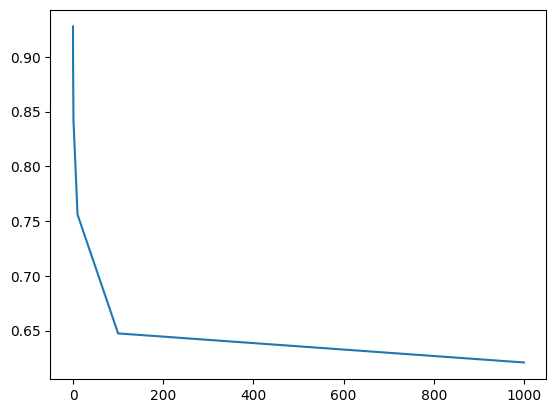

Best Score at alpha: 0.001
recall:  [0.96520343 0.95001744]
recall:  [0.98735009 0.97170372]
recall:  [0.97615116 0.96073822]
recall:  [18261  8411]

Multinomial Naive Bayes done!

Random Forest Classifier
precisionTest:  [0.87036654 0.7321718 ]
recallTest:  [0.9229249  0.86542146]
fscoreTest:  [0.89587552 0.79323968]
supportTest:  [4554 2088]

Random Forest Classifier done!

Support Vector Machine


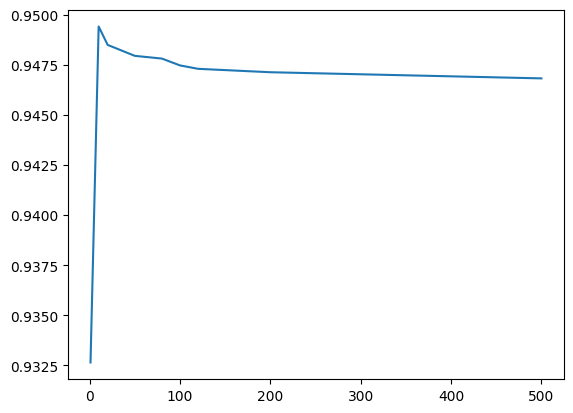

Best Score at C: 10


c:\Users\Lugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Lugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Lugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Lugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


recall:  [0.98146552 0.98649929]
recall:  [0.99753573 0.99036975]
recall:  [0.98943538 0.98843073]
recall:  [18261  8411]

Support Vector Machine done!

Dataset: dataset_1_no_stopword_stemm.csv
Bag of Words done
Dataset Split done
k Folds done
Logistic Regression
Logistic Regression done!

Multinomial Naive Bayes


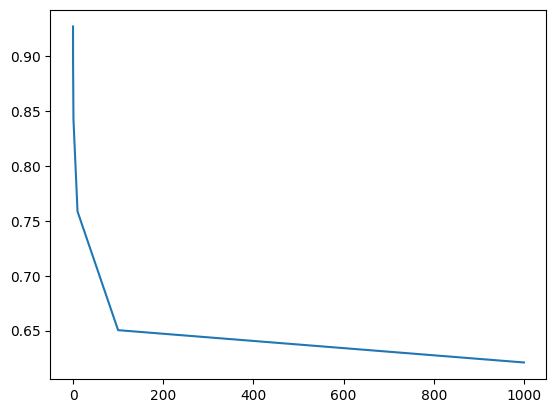

Best Score at alpha: 0.001
recall:  [0.96436239 0.93933486]
recall:  [0.98400876 0.97211014]
recall:  [0.97408652 0.9554415 ]
recall:  [18260  8426]

Multinomial Naive Bayes done!

Random Forest Classifier
precisionTest:  [0.87897563 0.73542601]
recallTest:  [0.93435785 0.87023637]
fscoreTest:  [0.90582101 0.7971719 ]
supportTest:  [4555 2073]

Random Forest Classifier done!

Support Vector Machine


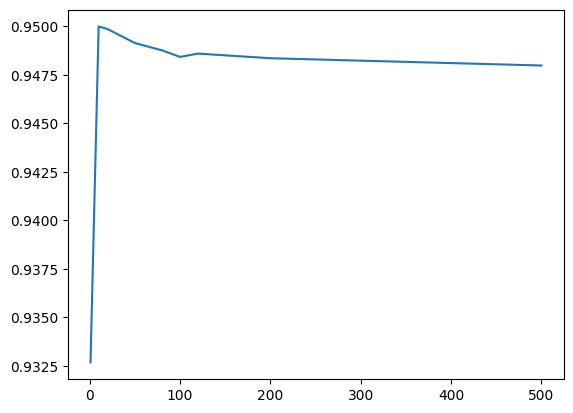

Best Score at C: 10


c:\Users\Lugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Lugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

In [10]:
# pasta de origem dos datasets
path = "./Post Cleaning Datasets/"

#função que itera sobre todos os itens da pasta sobre os arquivos .csv que existem 
for entry in os.scandir(path):    
    dataset = pd.read_csv(entry.path)  
    print("Dataset:", entry.name)

    # Aplicando Bag of Words
    X_bow, y_bow = bagOfWords(dataset)

    #Dividindo os dados 80/20 e Kfolds
    X_train, X_test, y_train, y_test = splitDataset(X_bow, y_bow)
    X_train_cv, X_test_cv, y_train_cv, y_test_cv = kFoldsCV(X_bow, y_bow)

    #Aplicando os Modelos ML
    
    print("Logistic Regression")
    #ogisticRegression(X_train, X_train_cv, X_test, y_train, y_train_cv, y_test, entry.name)
    print("Logistic Regression done!")
    print()

    print("Multinomial Naive Bayes")
    naiveBayes(X_train, X_train_cv, X_test, y_train, y_train_cv, y_test, entry.name)
    print("Multinomial Naive Bayes done!")
    print()

    print("Random Forest Classifier")
    randomForest(X_train, X_test, y_train, y_test, entry.name)
    print("Random Forest Classifier done!")
    print()

    print("Support Vector Machine")
    SVM(X_train, X_train_cv, X_test, y_train, y_train_cv, y_test, entry.name)
    print("Support Vector Machine done!")
    print()